<div style="background-color:#f4f6f8; border-left:6px solid #1976d2; padding:20px; border-radius:8px; font-family:Segoe UI, sans-serif;">

  <h1 style="color:#0d47a1;">News Summarizer using T5</h1>

  <p style="font-size:16px; color:#333;">
    This notebook demonstrates how to leverage a fine-tuned <b>T5 transformer</b> model to generate high-quality summaries from real Indian news articles. It includes data exploration, visual insights, and automatic text summarization using <code>t5-small-indian-news</code>.
  </p>

  <img src="https://media3.giphy.com/media/v1.Y2lkPTc5MGI3NjExaXFzbzA3Y3RoMDBtM202cmI1cHkzNTBhOHB4ZmdyNHNtYWw4cmIyciZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/RmrjX0CnxmHug/giphy.gif" width="300" style="border-radius:10px; margin-top:15px; box-shadow:0 4px 8px rgba(0,0,0,0.1);">

</div>


## Install Required Libraries

In [2]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import pandas as pd
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")

## Load & Prepare Dataset

In [3]:
df = pd.read_csv("/kaggle/input/news-articles/Articles.csv", encoding='latin1')

df = df[['Heading', 'Article', 'NewsType']].rename(columns={
    "Heading": "title",
    "Article": "content",
    "NewsType": "category"
})
df.dropna(subset=["content"], inplace=True)
df.reset_index(drop=True, inplace=True)

print("Loaded news articles:")
df.head()


Loaded news articles:


,title,content,category
0,sindh govt decides to cut public transport far...,KARACHI: The Sindh government has decided to b...,business
1,asia stocks up in new year trad,HONG KONG: Asian markets started 2015 on an up...,business
2,hong kong stocks open 0.66 percent lower,HONG KONG: Hong Kong shares opened 0.66 perce...,business
3,asian stocks sink euro near nine year,HONG KONG: Asian markets tumbled Tuesday follo...,business
4,us oil prices slip below 50 a barr,NEW YORK: US oil prices Monday slipped below $...,business


### Article Length Distribution

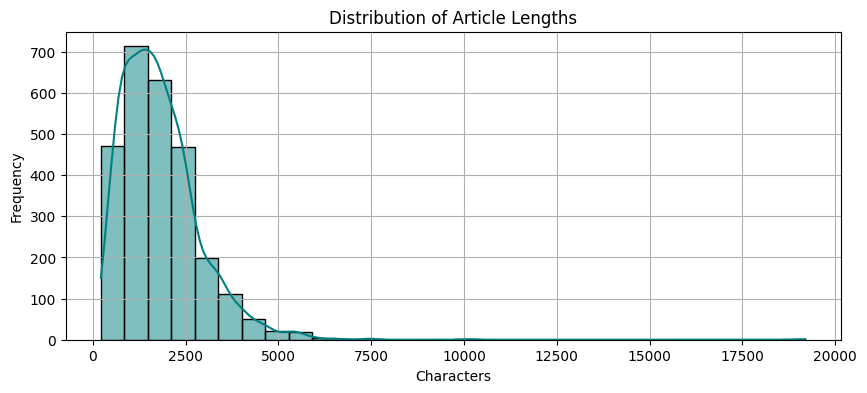

In [4]:
df['content_length'] = df['content'].apply(len)

plt.figure(figsize=(10, 4))
sns.histplot(df['content_length'], bins=30, kde=True, color="teal")
plt.title("Distribution of Article Lengths")
plt.xlabel("Characters")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

###  WordCloud of News Articles

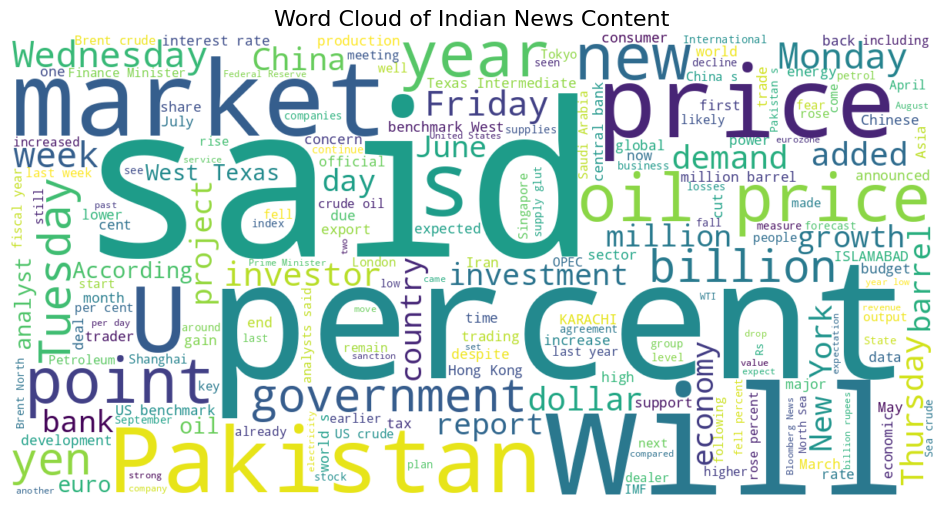

In [5]:
text_blob = " ".join(df['content'].tolist()[:300])
wordcloud = WordCloud(background_color='white', width=1200, height=600).generate(text_blob)

plt.figure(figsize=(15, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Indian News Content", fontsize=16)
plt.show()

## Load Fine-Tuned Summarization Model

In [7]:
model_path = "/kaggle/input/t5-small-indian-news/transformers/default/1/t5-small-indian-news/checkpoint-219"
tokenizer = T5Tokenizer.from_pretrained(model_path)
model = T5ForConditionalGeneration.from_pretrained(model_path)

def generate_summary(text, max_input=512, max_output=128):
    input_text = "summarize: " + text
    input_ids = tokenizer(input_text, return_tensors="pt", max_length=max_input, truncation=True).input_ids
    summary_ids = model.generate(input_ids, max_length=max_output, num_beams=4, early_stopping=True)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

## Summarize Sample Articles

In [8]:
sample_df = df.sample(5, random_state=42).reset_index(drop=True)
sample_df['summary'] = sample_df['content'].apply(generate_summary)

for i in range(len(sample_df)):
    print(f"📰 Title: {sample_df.loc[i, 'title']}")
    print(f"📂 Category: {sample_df.loc[i, 'category']}")
    print(f"📄 Original Article:\n{sample_df.loc[i, 'content'][:500]}...\n")
    print(f"🧾 Generated Summary:\n{sample_df.loc[i, 'summary']}\n")
    print("="*120)

📰 Title: Dutch climber dies descent Everest summi
📂 Category: sports
📄 Original Article:
strong>KATHMANDU:  A 36-year-old Dutch climber died while descending from the summit of Everest, the first to perish this year on the world's highest mountain, officials in Nepal said on Saturday.</strongEric Ary Arnold was among over 40 climbers who reached the 8,850 metre (29,035 feet) summit on Friday, but died later that day while coming down on high-altitude slopes known as the "death zone" because of the prevailing thin air, Tourism Department official Gyanendra Shrestha said.Mingma Sherpa...

🧾 Generated Summary:
A 36-year-old Dutch climber died while descending from the summit of Everest, the first to perish this year on the world's highest mountain, officials in Nepal said on Saturday./strongEric Ary Arnold was among over 40 climbers who reached the 8,850 metre (29,035 feet) summit on Friday, but died later that day while coming down on high-altitude slopes known as the "death zone" becaus

## Summary vs Article Word Count

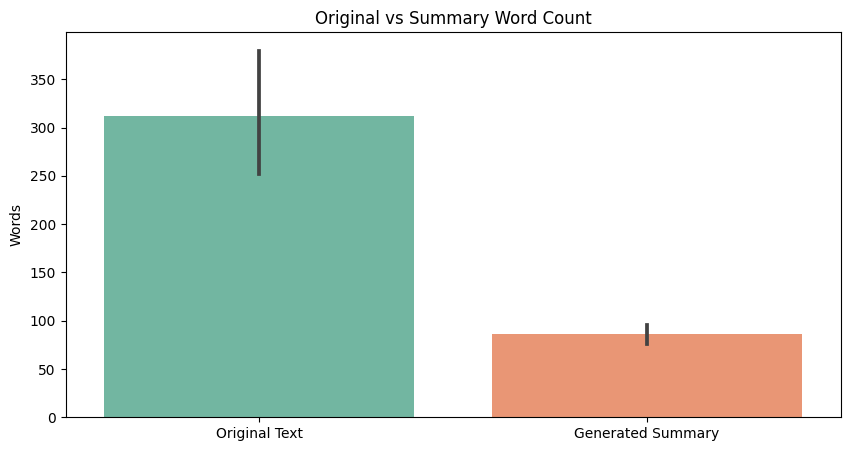

In [9]:
sample_df['original_len'] = sample_df['content'].apply(lambda x: len(x.split()))
sample_df['summary_len'] = sample_df['summary'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 5))
sns.barplot(data=sample_df[['original_len', 'summary_len']], palette='Set2')
plt.title("Original vs Summary Word Count")
plt.ylabel("Words")
plt.xticks([0, 1], ['Original Text', 'Generated Summary'])
plt.show()

## Category-wise Analysis and Visualization

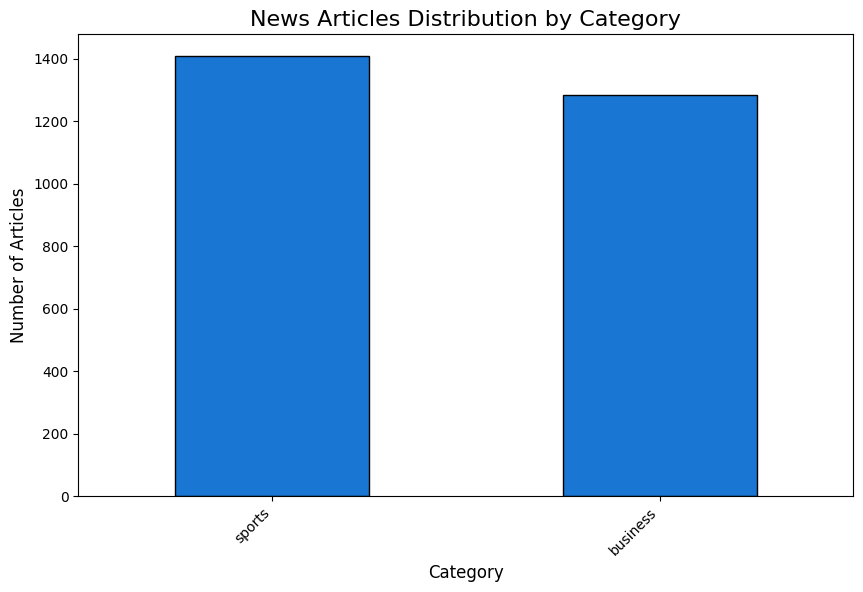

In [12]:
import matplotlib.pyplot as plt

category_counts = df['category'].value_counts()

# Plot the category-wise distribution
plt.figure(figsize=(10,6))
category_counts.plot(kind='bar', color='#1976d2', edgecolor='black')
plt.title("News Articles Distribution by Category", fontsize=16)
plt.xlabel("Category", fontsize=12)
plt.ylabel("Number of Articles", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()

## Text Preprocessing and Sentiment Analysis

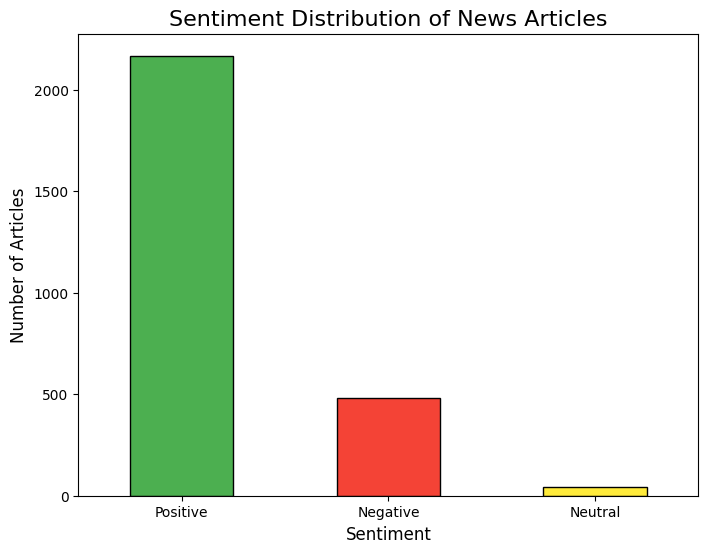

In [14]:
from textblob import TextBlob

# Define a function to get sentiment
def get_sentiment(text):
    blob = TextBlob(text)
    return 'Positive' if blob.sentiment.polarity > 0 else ('Negative' if blob.sentiment.polarity < 0 else 'Neutral')

# Apply sentiment analysis
df['Sentiment'] = df['content'].apply(get_sentiment)

# Count the sentiment distribution
sentiment_counts = df['Sentiment'].value_counts()

# Plot sentiment distribution
plt.figure(figsize=(8,6))
sentiment_counts.plot(kind='bar', color=['#4caf50', '#f44336', '#ffeb3b'], edgecolor='black')
plt.title("Sentiment Distribution of News Articles", fontsize=16)
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Number of Articles", fontsize=12)
plt.xticks(rotation=0)
plt.show()

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

# Prepare the data
X = df['content']  # Features (text)
y = df['category']  # Target (categories)

# Vectorize the text data (TF-IDF)
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_vec = vectorizer.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)

# Train a Random Forest model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9907235621521335
Classification Report:
               precision    recall  f1-score   support

    business       0.99      0.99      0.99       262
      sports       0.99      0.99      0.99       277

    accuracy                           0.99       539
   macro avg       0.99      0.99      0.99       539
weighted avg       0.99      0.99      0.99       539



# 📰 Indian News Article Summarizer

This demonstrates a Gradio interface powered by a fine-tuned T5 model (`t5-small-indian-news`) to summarize Indian news content. Just paste any article below and watch the magic!



In [17]:
!pip install -q gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 34.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.6/322.6 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 72.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.6 MB/s eta 0:00:00


In [21]:
import gradio as gr
from transformers import T5Tokenizer, T5ForConditionalGeneration

MODEL_PATH = "/kaggle/input/t5-small-indian-news/transformers/default/1/t5-small-indian-news/checkpoint-219"
tokenizer = T5Tokenizer.from_pretrained(MODEL_PATH)
model = T5ForConditionalGeneration.from_pretrained(MODEL_PATH)

def summarize_text_gradio(article):
    input_text = "summarize: " + article
    input_ids = tokenizer.encode(input_text, return_tensors="pt", max_length=512, truncation=True)
    
    summary_ids = model.generate(
        input_ids,
        max_length=100,
        num_beams=4,
        early_stopping=True
    )
    
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

import gradio as gr

with gr.Blocks(theme=gr.themes.Base()) as demo:
    gr.Markdown(
        """
        <div style="background-color:#121212;padding:20px;border-radius:10px;color:#00FF00;font-family:monospace;">
        <h2> News Summarizer Terminal</h2>
        <p>Welcome to the T5-powered summarization console.<br>Type or paste your article below and press 'RUN'.</p>
        </div>
        """,
        elem_id="terminal-header"
    )

    with gr.Row():
        with gr.Column(scale=1):
            article_input = gr.Textbox(
                lines=15,
                label="Input >",
                placeholder=">> Paste your article here...",
                show_copy_button=True,
                elem_id="input-terminal"
            )
            summarize_button = gr.Button("RUN", variant="primary")

        with gr.Column(scale=1):
            output_summary = gr.Textbox(
                label="Output >",
                lines=15,
                show_copy_button=True,
                elem_id="output-terminal"
            )

    summarize_button.click(fn=summarize_text_gradio, inputs=article_input, outputs=output_summary)

    demo.css = """
    #input-terminal textarea, #output-terminal textarea {
        background-color: #1e1e1e;
        color: #00FF00;
        font-family: 'Courier New', monospace;
        font-size: 14px;
        border-radius: 5px;
        border: 1px solid #00FF00;
    }
    button {
        background-color: #00FF00 !important;
        color: black !important;
        font-weight: bold;
        border: none;
        border-radius: 5px;
        padding: 8px 16px;
    }
    #terminal-header h2, #terminal-header p {
        margin: 0;
    }
    """

demo.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://058dbccbb39d515787.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


### 🖼️ Interface Preview

![Gradio UI Terminal Style](https://github.com/EchoSingh/News-Article-Summarizer/raw/main/interface-gradio.jpg)
